# Sprint0 - Lightweight model fine-tuning on a random subset of data

This sprint consists of pre-training a lightweight model.

The model is small enough that it can be trained on a macbook. Ensuring that you can train this model will pave the way for the next couple sprints.


### 1. Pip install necessary requirements


In [ ]:
!pip install --upgrade pip
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121
!pip install pandas numpy pyarrow
!pip install transformers
!pip install datasets accelerate matplotlib



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 71.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in indexes: https://download.pytorch.org/whl/cu121
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 187.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 174.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 115.5 MB/s eta 0:00:00

### 2. Load a pre-trained model & tokenizer


In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, DataCollatorWithPadding

# load the gpt-2 model and respective tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name)

# Move to MPS (if your computer is m1 macbook like mine) or CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
model.to(device)

/home/jayden/data-selection-project0-1/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [3]:
torch.cuda.device_count()

1

### 3. Load dataset of Common Crawl Data


In [4]:
from datasets import load_dataset, Dataset

# load small sample of common crawl dataset
dataset = load_dataset(
    "allenai/c4", "en", split="train", streaming=True, trust_remote_code=True
)
randomized_dataset = dataset.shuffle(seed=42)
# small_dataset = dataset.train_test_split(test_size=0.1)
print(randomized_dataset)

IterableDataset({
    features: ['text', 'timestamp', 'url'],
    num_shards: 1024
})


### 4.1 Load a subset of Common Crawl Data and limit the perplexity heuristic


In [6]:
# perplexities = []
def compute_perplexity(text):
    """Compute perplexity of a given text using GPT-2."""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(
        device
    )
    with torch.no_grad():  # Disable gradient computation for efficiency
        loss = model(**inputs, labels=inputs["input_ids"]).loss
    return torch.exp(loss).item()  # Convert loss to perplexity


# Define heuristic filter: Keep texts with moderate perplexity
def heuristic_filter(example, low_perp_full, med_perp_full, high_perp_full):
    perplexity = compute_perplexity(example["text"])
    # perplexities.append(perplexity)
    if perplexity < 50 and not low_perp_full:
        return "low"
    elif 50 <= perplexity < 100 and not med_perp_full:
        return "medium"
    elif perplexity >= 100 and not high_perp_full:
        return "high"
    else:
        return None

    # return (
    #     lower_bound < perplexity <= upper_bound
    # )  # Adjust thresholds based on your needs


# Apply heuristic filtering on the streaming dataset

# filtered_dataset = (example for example in dataset if heuristic_filter(example))
# small_dataset = []
# for i, example in enumerate(randomized_dataset):
#     if len(small_dataset) >= 100_000:
#         break
#     elif len(small_dataset) % 1000 == 0:
#         print(len(small_dataset))
#     if heuristic_filter(example):
#         small_dataset.append(example)
# print(small_dataset)
# print(len(small_dataset))

### 4.2 Tokenize with updated fields to fit the expected shape


In [23]:
def tokenize_train(dataset, tokenizer, token_max=100_000, heuristic=True):
    """Tokenizer function for streamed dataset"""
    count_dict = {"low": 0, "medium": 0, "high": 0}
    current_token_count = 0
    target_perp = None
    for example in dataset:
        # if lb == 0 and ub == 50 and current_token_count > 0.1 * token_max:
        #     lb = 50
        #     ub = 100
        # elif lb == 50 and ub == 100 and current_token_count > 0.9 * token_max:
        #     lb = 100
        #     ub = 1000
        if heuristic:
            target_perp = heuristic_filter(
                example,
                count_dict["low"] > 0.1 * token_max,
                count_dict["medium"] > 0.7 * token_max,
                count_dict["high"] > 0.2 * token_max,
            )
            if not target_perp:
                continue

        # print(example)
        tokenized = tokenizer(
            example["text"], truncation=True, padding="max_length", max_length=512
        )
        input_ids = tokenized["input_ids"]
        tokenized["labels"] = tokenized["input_ids"].copy()
        if target_perp:
            count_dict[target_perp] += len(input_ids)
        current_token_count += len(input_ids)
        if current_token_count >= token_max:
            break
        yield tokenized


# tokenized_dataset = small_dataset.map(tokenize_func, batched=True).with_format("torch")
train_dataset = Dataset.from_generator(
    lambda: tokenize_train(randomized_dataset, tokenizer)
)
train_dataset = train_dataset.with_format("torch")

print(train_dataset)
total_samples = len(train_dataset)
print(total_samples)

model.resize_token_embeddings(len(tokenizer))
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)
train_dataset = train_dataset.shuffle(seed=42)

Generating train split: 195 examples [00:06, 30.54 examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 195
})
195


### 5. Train the model


In [24]:
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

#### Validation Set

In [11]:
val_dataset = load_dataset(
    "allenai/c4", "en", split="validation", streaming=True, trust_remote_code=True
)
save_dir = "./c4_validation_dataset"


def tokenize_val(dataset, tokenizer, token_max=1_000_000, heuristic=True):
    current_token_count = 0
    for example in dataset:
        # print(example)
        tokenized = tokenizer(
            example["text"], truncation=True, padding="max_length", max_length=512
        )
        input_ids = tokenized["input_ids"]
        tokenized["labels"] = tokenized["input_ids"].copy()
        current_token_count += len(input_ids)
        if current_token_count >= token_max:
            break
        yield tokenized


val_dataset = Dataset.from_generator(lambda: tokenize_val(val_dataset, tokenizer))
val_dataset = val_dataset.with_format("torch")

Generating train split: 1953 examples [00:03, 615.51 examples/s] 


In [27]:
from transformers import TrainingArguments, Trainer
import os

os.environ["WANDB_DISABLED"] = "true"
train_dataset_size = len(train_dataset)
batch_size = 8
epochs = 1

# Calculate the total number of training steps
steps_per_epoch = train_dataset_size // batch_size
total_train_steps = steps_per_epoch * epochs

# Set eval_steps to 1/4 of total steps
eval_steps = total_train_steps // 4
logging_steps = total_train_steps // 4

# Define training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-perplexity-special-2",
    run_name="project0",
    eval_strategy="steps",
    eval_steps=eval_steps,
    save_steps=eval_steps,
    logging_steps=logging_steps,
    save_strategy="steps",
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=1,
    num_train_epochs=epochs,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    # max_steps=total_samples,
    learning_rate=1e-4,
    logging_dir="./logs",
    remove_unused_columns=False,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

trainer.train()  # Only works with 1 gpu in the ipynb notebook

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_2129936/3001797346.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [14]:
trainer.save_model("./gpt2-final-models/perplexity-1e5")

### 6. Model Evaluation on Downstream Task

In [ ]:
# Load any model from checkpoint
checkpoint_path_1e6 = "./gpt2-finetuned/checkpoint-3162"

model_1e6 = AutoModelForCausalLM.from_pretrained(checkpoint_path_1e6)
tokenizer_1e6 = AutoTokenizer.from_pretrained(checkpoint_path_1e6)
model_1e6.to(device)
model_1e6.eval()

checkpoint_path_1e7 = "./gpt2-finetuned/checkpoint-19531"

model_1e7 = AutoModelForCausalLM.from_pretrained(checkpoint_path_1e7)
tokenizer_1e7 = AutoTokenizer.from_pretrained(checkpoint_path_1e7)
model_1e7.to(device)
model_1e7.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [12]:
model.eval()


def run_query(query, model, tokenizer, max_new_tokens=50):
    inputs = tokenizer(query, return_tensors="pt").to(device)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    with torch.no_grad():
        output = model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.95,
        )
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text


query = "I am"
response = run_query(query, model, tokenizer)
print(f"GPT-2: {response}", flush=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


GPT-2: I am a small man with a lot of problems. I have a lot of trouble sleeping. I am very tired. I am very much interested in finding out how to get back to the bed with the help of a friend who is a professional. I hope


### 6. Perplexities Plot


In [19]:
import matplotlib.pyplot as plt
import statistics
import numpy as np

# Assuming 'trainer.state.log_history' has loss values
# losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]
# steps = list(range(len(losses)))
# losses = [2.0841,2.0071,1.8397,1.7660,1.6171,1.6674,1.5222,1.5026,1.3644,1.4413,1.2716,1.3546,1.2873,1.1856,1.2091,1.1446,1.1150,1.1507,1.1318,1.0734]
# steps = [500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000]
print("mean: " + str(statistics.mean(perplexities)))
print("lower quartile: " + str(np.percentile(perplexities, 25)))
print("median: " + str(statistics.median(perplexities)))
print("upper quartile: " + str(np.percentile(perplexities, 75)))
print("Sample size: " + str(len(perplexities)))
plt.plot(perplexities, marker="o")
plt.xlabel("Samples")
plt.ylabel("perplexities")
plt.title("Perplexities vs Samples")
plt.show()

StatisticsError: mean requires at least one data point

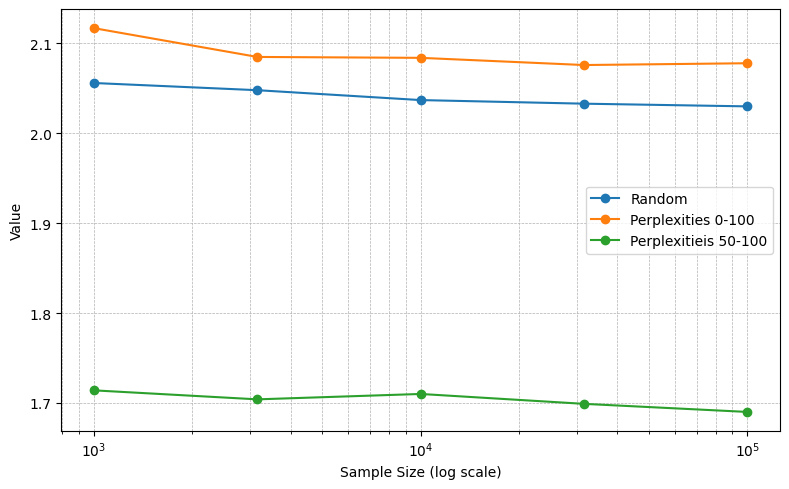

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import LogLocator, LogFormatterMathtext

sample_sizes = [1000, 3162, 10_000, 31_622, 100_000]
random = [2.056, 2.048, 2.037, 2.033, 2.030]
perplexity_1 = [2.117, 2.085, 2.084, 2.076, 2.078]
perplexity_2 = [1.714, 1.704, 1.710, 1.699, 1.690]

plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, random, marker="o", label="Random")
plt.plot(sample_sizes, perplexity_1, marker="o", label="Perplexities 0-100")
plt.plot(sample_sizes, perplexity_2, marker="o", label="Perplexitieis 50-100")

plt.xscale("log")
plt.gca().xaxis.set_major_locator(LogLocator(base=10.0))
plt.gca().xaxis.set_major_formatter(LogFormatterMathtext())

plt.xlabel("Sample Size (log scale)")
plt.ylabel("Value")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

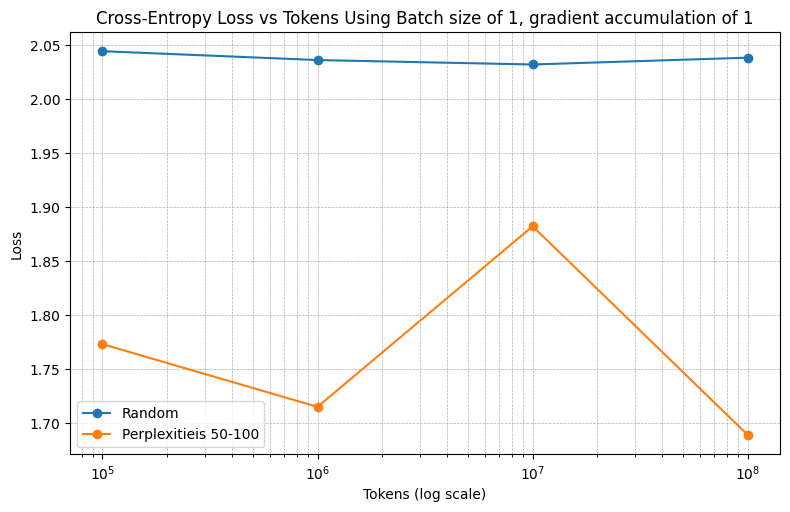

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import LogLocator, LogFormatterMathtext

token_sizes = [1e5, 1e6, 1e7, 1e8]
random = [2.044, 2.0358, 2.0317, 2.038]
perplexity = [1.773, 1.715, 1.882, 1.689]


plt.figure(figsize=(8, 5))
plt.plot(token_sizes, random, marker="o", label="Random")
# plt.plot(token_sizes, perplexity_1, marker="o", label="Perplexities 0-100")
plt.plot(token_sizes, perplexity, marker="o", label="Perplexitieis 50-100")

plt.xscale("log")
plt.gca().xaxis.set_major_locator(LogLocator(base=10.0))
plt.gca().xaxis.set_major_formatter(LogFormatterMathtext())

plt.xlabel("Tokens (log scale)")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.title(
    "Cross-Entropy Loss vs Tokens Using Batch size of 1, gradient accumulation of 1"
)
plt.show()

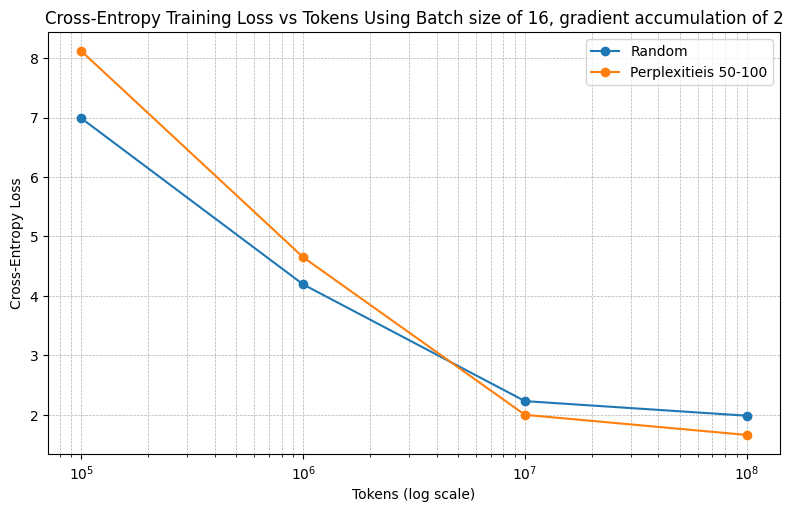

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import LogLocator, LogFormatterMathtext

token_sizes = [1e5, 1e6, 1e7, 1e8]
random = [6.9862213134765625, 4.192551676432291, 2.229334583469466, 1.9839093039888855]
perplexity = [
    8.116313934326172,
    4.649463907877604,
    1.9986129461550246,
    1.6605193136872658,
]


plt.figure(figsize=(8, 5))
plt.plot(token_sizes, random, marker="o", label="Random")
# plt.plot(token_sizes, perplexity_1, marker="o", label="Perplexities 0-100")
plt.plot(token_sizes, perplexity, marker="o", label="Perplexitieis 50-100")

plt.xscale("log")
plt.gca().xaxis.set_major_locator(LogLocator(base=10.0))
plt.gca().xaxis.set_major_formatter(LogFormatterMathtext())

plt.xlabel("Tokens (log scale)")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.title(
    "Cross-Entropy Training Loss vs Tokens Using Batch size of 16, gradient accumulation of 2"
)
plt.show()

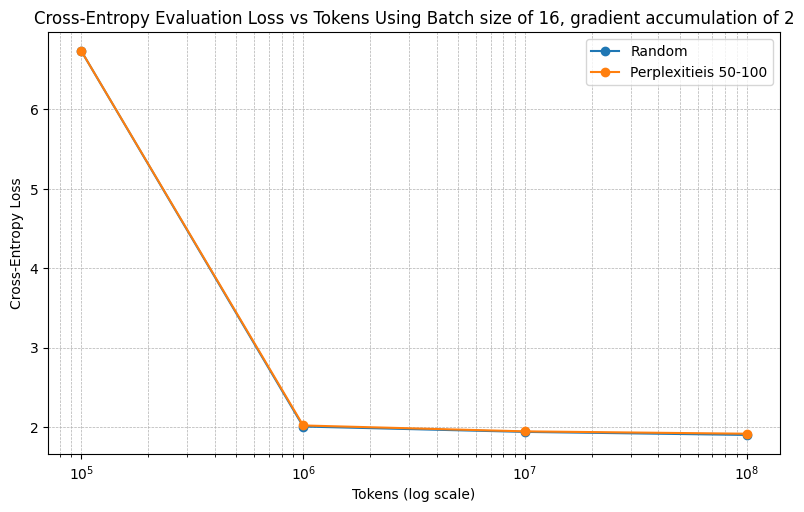

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import LogLocator, LogFormatterMathtext

token_sizes = [1e5, 1e6, 1e7, 1e8]
random = [6.731801986694336, 2.0069291591644287, 1.939154863357544, 1.90092134475708]
perplexity = [
    6.731801986694336,
    2.0202713012695312,
    1.9458389282226562,
    1.9161430597305298,
]


plt.figure(figsize=(8, 5))
plt.plot(token_sizes, random, marker="o", label="Random")
# plt.plot(token_sizes, perplexity_1, marker="o", label="Perplexities 0-100")
plt.plot(token_sizes, perplexity, marker="o", label="Perplexitieis 50-100")

plt.xscale("log")
# plt.ylim(1.8, 2.2)
plt.gca().xaxis.set_major_locator(LogLocator(base=10.0))
plt.gca().xaxis.set_major_formatter(LogFormatterMathtext())

plt.xlabel("Tokens (log scale)")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.title(
    "Cross-Entropy Evaluation Loss vs Tokens Using Batch size of 16, gradient accumulation of 2"
)
plt.show()

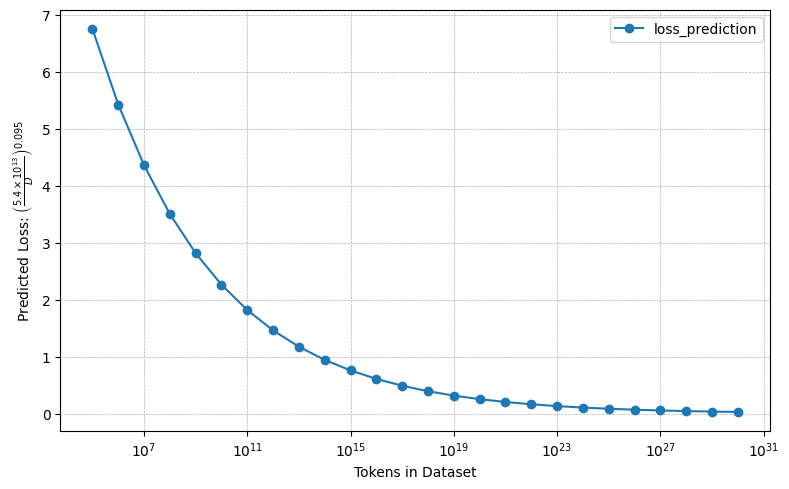

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import LogLocator, LogFormatterMathtext

D = np.array(
    [
        1e5,
        1e6,
        1e7,
        1e8,
        1e9,
        1e10,
        1e11,
        1e12,
        1e13,
        1e14,
        1e15,
        1e16,
        1e17,
        1e18,
        1e19,
        1e20,
        1e21,
        1e22,
        1e23,
        1e24,
        1e25,
        1e26,
        1e27,
        1e28,
        1e29,
        1e30,
    ]
)


def loss_prediction_func(D):
    return ((5.4 * (10**13)) / D) ** 0.095


# def threshold_ratio_func(D):
#     return (loss_prediction_func(D) - loss_prediction_func(D // 10)) / (9 * (D // 10))


plt.figure(figsize=(8, 5))
plt.plot(D, loss_prediction_func(D), marker="o", label="loss_prediction")
# plt.plot(D, threshold_ratio_func(D), marker="o", label="threshold_ratio")
# plt.plot(sample_sizes, perplexity_2, marker="o", label="Perplexitieis 50-100")

plt.xscale("log")
plt.gca().xaxis.set_major_locator(LogLocator(base=10.0))
plt.gca().xaxis.set_major_formatter(LogFormatterMathtext())

plt.xlabel("Tokens in Dataset")
plt.ylabel(r"Predicted Loss: $\left(\frac{5.4 \times 10^{13}}{D}\right)^{0.095}$")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

In [ ]:
D = np.array(
    [
        1e5,
        1e6,
        1e7,
        1e8,
        1e9,
        1e10,
        1e11,
        1e12,
        1e13,
        1e14,
        1e15,
        1e16,
        1e17,
        1e18,
        1e19,
        1e20,
        1e21,
        1e22,
        1e23,
        1e24,
        1e25,
        1e26,
        1e27,
        1e28,
        1e29,
        1e30,
    ]
)


def threshold_ratio_func(dataset_size):
    return (
        loss_prediction_func(dataset_size // 10) - loss_prediction_func(dataset_size)
    ) / (9 * (dataset_size // 10))


threshold_ratios = [threshold_ratio_func(d) for d in D]
print(threshold_ratios)

plt.figure(figsize=(8, 5))
# plt.plot(D, loss_prediction_func(D), marker="o", label="loss_prediction")
plt.plot(D, threshold_ratios, marker="o", label="threshold_ratio")
# plt.plot(sample_sizes, perplexity_2, marker="o", label="Perplexitieis 50-100")

plt.xscale("log")
plt.gca().xaxis.set_major_locator(LogLocator(base=10.0))
plt.gca().xaxis.set_major_formatter(LogFormatterMathtext())

plt.xlabel("Tokens in Dataset")
plt.ylabel("Threshhold_ratio")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()